# [기본과제] MNIST 분류 모델 구현

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
from torch import nn

import os
import numpy as np

os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [5]:
batch_size = 256

In [7]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data/train',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

## 1. Test 데이터 준비하기
- Test data는 MNIST의 train data를 load하는 코드에서 `train=False`로 두면 됩니다.
- Train data와 마찬가지로 test data에 대한 data loader를 생성해주시면 됩니다(batch size는 동일하게 적용).
    - Test data는 랜덤하게 섞일 필요가 없기 때문에 `shuffle=False`로 설정합니다.


In [17]:
testset = torchvision.datasets.MNIST(
    root = './data/test',
    train = False, # [MYCODE] train = False로 설정
    download = True,
    transform = transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size, # [MYCODE] train data와 batch size는 동일하게 적용
    shuffle=False # [MYCODE] shuffle = False로 설정
)

In [11]:
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
#plt.imshow(trainset[0][0][0], cmap='gray')

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

60000
torch.Size([1, 28, 28]) 5
torch.Size([256, 1, 28, 28]) torch.Size([256])


## 2. CrossEntropyLoss 적용하기
변경되어야 할 점은 2가지로 i) `Model`의 최종 output의 dimension과 ii) `loss` 계산 부분입니다.

In [13]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # [MYCODE] 0-9 총 10개의 숫자로 classification하기 위해 최종 output 차원을 10으로 설정

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # remove activation function from the final layer

    return x


model = Model(28 * 28 * 1, 1024)

loss_fn = nn.CrossEntropyLoss()

In [14]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

## [LOG] 출력 결과

In [20]:
n_epochs = 100
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.

  train_cnt = 0
  train_acc = 0
  test_cnt = 0
  test_acc = 0

  if not model.training:
    model.train()

  for inputs, labels in trainloader:
    model.zero_grad()
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels) # [MYCODE] loss 계산 부분을 MSE -> CrossEntropyLoss로 변경

    preds = torch.argmax(preds, dim=1)

    train_cnt += labels.shape[0]
    train_acc += (preds == labels).sum().item()

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  train_accs.append(train_acc / train_cnt)

  model.eval()
  with torch.no_grad():
    for inputs, labels in testloader:
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)

      preds = torch.argmax(preds, dim=1)

      test_cnt += labels.shape[0]
      test_acc += (preds == labels).sum().item()
    test_accs.append(test_acc / test_cnt)

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 416.7664723396301
Epoch   1 | Loss: 398.51677799224854
Epoch   2 | Loss: 379.12319552898407
Epoch   3 | Loss: 359.14193773269653
Epoch   4 | Loss: 339.0579639673233
Epoch   5 | Loss: 319.3543281555176
Epoch   6 | Loss: 300.5852905511856
Epoch   7 | Loss: 282.9577376842499
Epoch   8 | Loss: 266.75423562526703
Epoch   9 | Loss: 251.91064631938934
Epoch  10 | Loss: 238.49543511867523
Epoch  11 | Loss: 226.5168740749359
Epoch  12 | Loss: 215.6572739481926
Epoch  13 | Loss: 205.92915606498718
Epoch  14 | Loss: 197.29247516393661
Epoch  15 | Loss: 189.33203262090683
Epoch  16 | Loss: 182.2590315937996
Epoch  17 | Loss: 175.84935462474823
Epoch  18 | Loss: 169.93870741128922
Epoch  19 | Loss: 164.6288941502571
Epoch  20 | Loss: 159.76039791107178
Epoch  21 | Loss: 155.3054115176201
Epoch  22 | Loss: 151.1298267841339
Epoch  23 | Loss: 147.39094996452332
Epoch  24 | Loss: 143.93587988615036
Epoch  25 | Loss: 140.66331142187119
Epoch  26 | Loss: 137.72429403662682
Epoch  27 | 

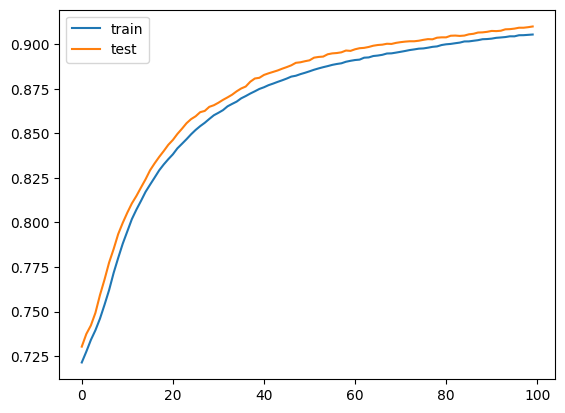

In [25]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accs, test_accs)

In [24]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[ 2.0017, -4.2247,  0.7412,  4.8462, -5.9336,  4.6369, -2.7028,  0.0074,
          1.0637, -0.4436]], device='cuda:0', grad_fn=<AddmmBackward0>)
5
